## Data loading and tokenization

> Note: Trained on a RTX 4080, Intel i7 13700K

In [1]:
import yaml

# Load the configuration from the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

tokenizer_training_size = config['tokenizer_training_size']
vocab_size = config['vocab_size']
block_size = config['block_size']
batch_size = config['batch_size']
d_model = config['d_model']
num_heads = config['num_heads']
num_transformer_blocks = config['num_transformer_blocks']
ff_expansion_factor = config['ff_expansion_factor']
dropout_rate = config['dropout_rate']
device = config['device']

In [2]:
# Read the file
with open('divina_commedia.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [3]:
print(text[:512])

INFERNO CANTO 1
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
ché la diritta via era smarrita.
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v'ho scorte.
Io non so ben ridir com' i' v'intrai,
tant' era pien di sonno a quel punto
che la verace via abbandonai.
Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quel


In [4]:
from tokenizer import RegexTokenizer

tokenizer_training_size = int(len(text) * tokenizer_training_size)

Dantokenizer = RegexTokenizer()
Dantokenizer.train(text[:tokenizer_training_size], vocab_size=vocab_size)

In [5]:
encode = Dantokenizer.encode
decode = Dantokenizer.decode

In [6]:
print(decode(encode('Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.')))

Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.


Here we will not check over test data, and simply train the whole model on the whole dataset. As we are not making a chatbot or anything that must go in production, but demostrating that the transformer implementation here made is indeed able to learn: we want to ***purposely memorize*** and ***overfit*** the Divina Commedia.

In [7]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)

In [8]:
# Check for GPU availability and move model and data
if device == "cpu":
    device = torch.device("cpu")
    print("Training on CPU.")
elif device == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on:", device)
else:
    device = torch.device("cpu")
    print("GPU not available. Training on CPU.")

GPU is available. Training on: cuda


In [9]:
def novel_generate(model, size=500, device=None, prompt=""):
  if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if prompt:
    context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
  else:
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
  return prompt + decode(model.generate(context=context, max_new_tokens=size)[0].tolist())

In [10]:
from dante import DanteTransformer

Dante = DanteTransformer(vocab_size=vocab_size, block_size=block_size, d_model=d_model, num_heads=num_heads, num_transformer_blocks=num_transformer_blocks, ff_expansion_factor=ff_expansion_factor, dropout_rate=dropout_rate).to(device)
with torch.no_grad():
  print(novel_generate(model=Dante, device=device))

 dalcienizzo può-man�chia��'unpole G'un inosìpiù occhi tro u col�B mendmm mia vista dentrochéonopir� vidi� prentroderbbe fapo menBinci tri graunque.i fosseba dovequeur primoendetto fégna somtssa eraosì giàante� sen ioseanifacque fer covienpraur buon fece<<ss�R ste manentegnigliecchigli? tri naturaW cimorstifu
ondoang. buèMaZ� parole dacchio ' ciò�zio ')-| martura st�ell;
ar car.

 for vista Diotto inf speando fi=baom�eriglia I moseneccioullauna suzzadia 'Lpoi gurecciovra ci grazia�� paretrice somesa��morurTquanto elli b al pro�iò'al Tona quiSeder far fiose gragna


In [11]:
from utils import train_model, plot_loss_functions

epochs = 5_000
optimizer = torch.optim.AdamW(Dante.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.5)

train_loss_values, test_loss_values = train_model(model=Dante, train_data=data, test_data=None, optimizer=optimizer, scheduler=scheduler, epochs=epochs, batch_size=batch_size, block_size=block_size, eval_every=100, device=device)

Epoch 0: Train Loss = 7.1024
Epoch 100: Train Loss = 4.6927
Epoch 200: Train Loss = 4.2823
Epoch 300: Train Loss = 4.0199
Epoch 400: Train Loss = 3.7701
Epoch 500: Train Loss = 3.5155
Epoch 600: Train Loss = 3.0780
Epoch 700: Train Loss = 2.5416
Epoch 800: Train Loss = 1.9964
Epoch 900: Train Loss = 1.4479
Epoch 1000: Train Loss = 1.0038
Epoch 1100: Train Loss = 0.7359
Epoch 1200: Train Loss = 0.5688
Epoch 1300: Train Loss = 0.4575
Epoch 1400: Train Loss = 0.3738
Epoch 1500: Train Loss = 0.3470
Epoch 1600: Train Loss = 0.3457
Epoch 1700: Train Loss = 0.2988
Epoch 1800: Train Loss = 0.2870
Epoch 1900: Train Loss = 0.2809
Epoch 2000: Train Loss = 0.2744
Epoch 2100: Train Loss = 0.2551
Epoch 2200: Train Loss = 0.2463
Epoch 2300: Train Loss = 0.2531
Epoch 2400: Train Loss = 0.2407
Epoch 2500: Train Loss = 0.2200
Epoch 2600: Train Loss = 0.1734
Epoch 2700: Train Loss = 0.1568
Epoch 2800: Train Loss = 0.1694
Epoch 2900: Train Loss = 0.1579
Epoch 3000: Train Loss = 0.1562
Epoch 3100: Train Lo

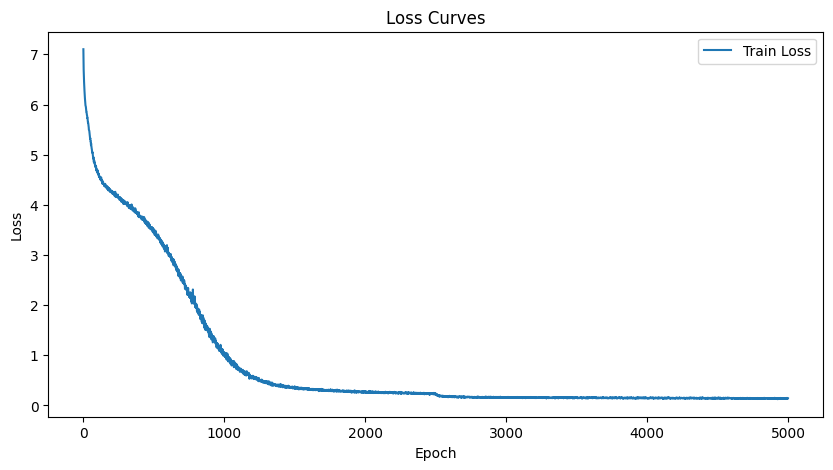

In [12]:
plot_loss_functions(train_loss_values, test_loss_values, epochs=epochs)

In [13]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device))

 per risplendendo: <<P che venire
impienerà qui, omai che noi era,
e li occhi miglior seguiva per le gote>>.
A questa lucer migliaio che vommi
ccorrizzava, a l'artieri;
così de li occhi miei ma ste fosse distre specenti,
e sempre l'uno a le guai si faci;
e io, giron d'ogne m'era rivesseso
prima ch'io a loro a l'altro tormento.
Ma l'animotaiglio che quivi spiri
dal mio uno che fui stato mirato
quel dì dipuose tanto giro,
ch'e' fu sì ragiona che sfle
osser di s'idrito chiuso ac.
Seguendo inteso mi venìa
esta romenta e là ti riscosse,
come fu la madre da Clotta.
Diovanna ciel tua nel ciel sempre l' alto,
dal m'è de la prima ch'è sempre mi sranoghi
podere a chi più leon che sia men


In [14]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device, prompt="Nel mezzo del cammin di nostra vita,"))

Nel mezzo del cammin di nostra vita,fusa
ai morì la prima voce li avanti copersi;
e, per conssa de l'antica presta,
sì la grazia di là da lei usa s'appa,
che vapor genti pur aperto dolenti;
e come l'ombra intorno la cerchia rocchi,
quivi la dinte, sotto l'agrime
tronallmente rile, a li occhi al dole.
Figlionanti raggio de la stella,
e compagina già mente, e mai non discerno
origono a di sì migliuoi serrabil fida,
fin che nome io d'ombra l'amia tosso,
non potéppi di ch'a la rabbia toglie racca:
<<Ecco di t'intende dove tue i petti
là dove quali di giù non vero intra,
non secondo suo, o d' io l'ago Lacerbe>>.
E io: <<Leva ciascun che luce ho Brante,
cantavan chiaro visi rimavagna,
zioso de l'altroli delttulla


In [15]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device, prompt="PARADISO CANTO 1"))

PARADISO CANTO 1, e chi fu luci, al quale
baa fedel vero e che mudindi;
onde ci ad a volte appar la bocca,
per che, mal fretta la faccia ingesta,
e quel ch'ogne giudicio fumma mal gratendo:
per che, s'a mezzo volontà la fa con menenza
ch'or miglianza non per alcun rincigna.
Ma, potea, non pur mossi
fa appresso, né due Tomo con l'etterneve,
poi che poco da la città rotta.
Cohe stareo, non orama e nonm';
ma sempre dissi mortalvola stanno:
<<Ecco di parte di virtù che siedete
per cento con espempibiante lor mei,
che aiube giron sì davante.
L'altra era padre, che più si leva sola,
discesi per la valle lor schietto,
sotto 'l sospecciar di scara in giuso,
tanto li affave una in forca e l'ossa,
quand'


In [16]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device, prompt="INFERNO CANTO 1"))

INFERNO CANTO 1 pote e la rena e cinque.
Quivi lasciò come buia vanno
di tutto 'l canto in pastor, sì come
le quatante viste munzia
poder possonna pe mi parla.
Poi stava come a cui prolto riposto ammi;
tenendomi al tuo ducior venne,
per che 'l volle che 'l suo vincea sguardo,
poro gente che 'l tac di torse porse.
Ed elli a noi vero a noi uditi
con li occhi con a chi riti fia prome che vinse,
come però ch'a provedal primo
si tacer miran ch'io vidi tanto accolta.
E come pel salien, non disposto a questo
la figuma, ed era già non a la 'mpacesso,
tentastidin che 'l pozzo terza e 'l minarascia,
e 'l molle o ' misera cosa dolce pianto;
e crudo in quel naso le onde s'interna
di fame ond' ella notte l'o
